<a href="https://colab.research.google.com/github/Zsh3178/color-classification/blob/main/color_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

install kaggle




In [1]:
!pip install kaggle

import libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
import tensorflow as tf
import pathlib
import random
from PIL import Image



from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

read kaggle.json file

In [3]:
!chmod 600 /content/kaggle.json

In [4]:
import os
os.environ['KAGGLE_USERNAME']= 'zsh1999'
os.environ['KAGGLE_KEY']= 'ed76912213c59803c272633e70556f7a'

download dataset color-classification

In [5]:
!kaggle datasets download -d ayanzadeh93/color-classification

 92% 149M/161M [00:01<00:00, 107MB/s] 
100% 161M/161M [00:02<00:00, 84.6MB/s]


Extract the downloaded file

In [6]:
import zipfile

# Replace 'path_to_zip_file.zip' with the actual path to your downloaded ZIP file
zip_file_path = '/content/color-classification.zip'

# Replace 'extracted_folder' with the desired name for the extracted folder
extracted_folder = '/content/Data'

# Create the target directory if it doesn't exist
import os
os.makedirs(extracted_folder, exist_ok=True)

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

print("ZIP file extracted successfully.")


ZIP file extracted successfully.


In [7]:
! cd /content/Data/ColorClassification

#CHANGE THE TERMINAL WORKING DIRECTORY ( LINUX COMMAN ) TO DO SOME CHANGES IN DATA DIRECTORY


To initiate changes to the directory and prepare the directory for creating the IMAGE DATA GENERATOR

In [8]:
#DELETE MASK DIRECTORYES
!rm -r /content/Data/ColorClassification/mask_black
!rm -r /content/Data/ColorClassification/mask_blue
!rm -r /content/Data/ColorClassification/mask_brown
!rm -r /content/Data/ColorClassification/mask_green
!rm -r /content/Data/ColorClassification/mask_orange
!rm -r /content/Data/ColorClassification/mask_red
!rm -r /content/Data/ColorClassification/mask_violet
!rm -r /content/Data/ColorClassification/mask_white
!rm -r /content/Data/ColorClassification/mask_yellow



!rm -r /content/Data/ColorClassification/mask_test
!rm -r /content/Data/ColorClassification/testimg
!rm -r /content/Data/ColorClassification/color-classification



show dataset


In [9]:
ls Data/ColorClassification

Black/  Brown/  hw3.m~      m_images.txt  red/         tm_images.txt  White/
Blue/   Green/  images.txt  orange/       timages.txt  Violet/        yellow/


In [10]:
data_dir ='/content/Data/ColorClassification'
data_dir = pathlib.Path(data_dir).with_suffix('')

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


114


See some examples of datasets



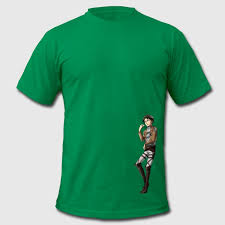

In [11]:
Green = list(data_dir.glob('Green/*'))
PIL.Image.open(str(Green[0]))

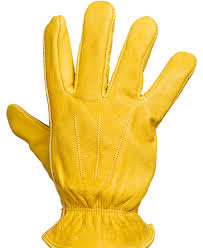

In [12]:
yellow = list(data_dir.glob('yellow/*'))
PIL.Image.open(str(yellow[0]))

Creating train dataset and validation dataset

In [13]:
batch_size = 32
img_height = 180
img_width = 180

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 117 files belonging to 9 classes.
Using 106 files for training.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 117 files belonging to 9 classes.
Using 11 files for validation.


In [16]:
class_names = train_ds.class_names
print(class_names)

['Black', 'Blue', 'Brown', 'Green', 'Violet', 'White', 'orange', 'red', 'yellow']


Here are the first nine images from the training dataset:


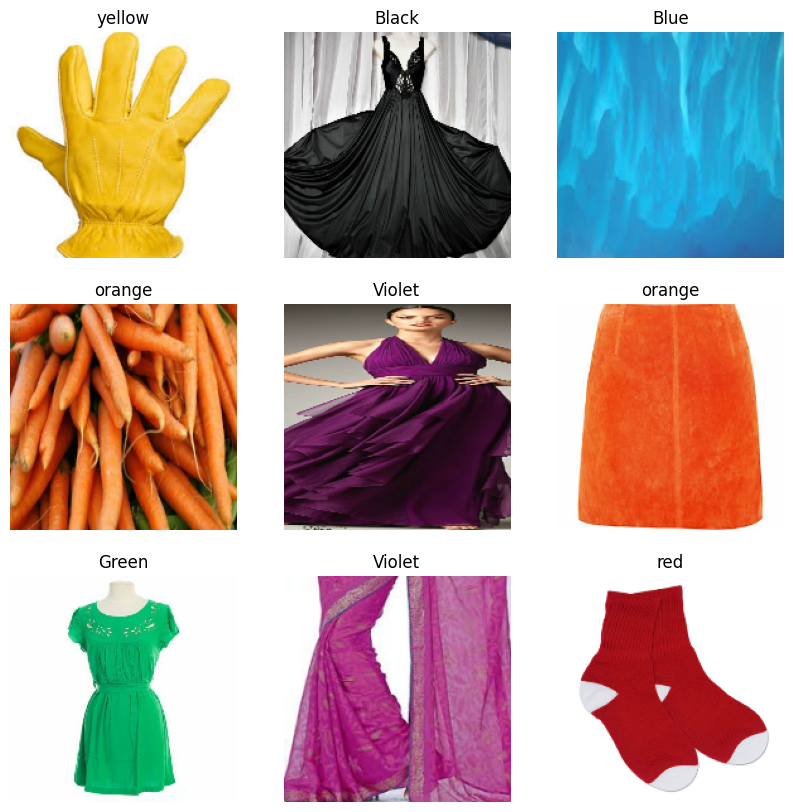

In [17]:

plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


shape of image_batch and label_batch

In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Configure the dataset for performance


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)




data_augmentation

In [20]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),

  ]
)

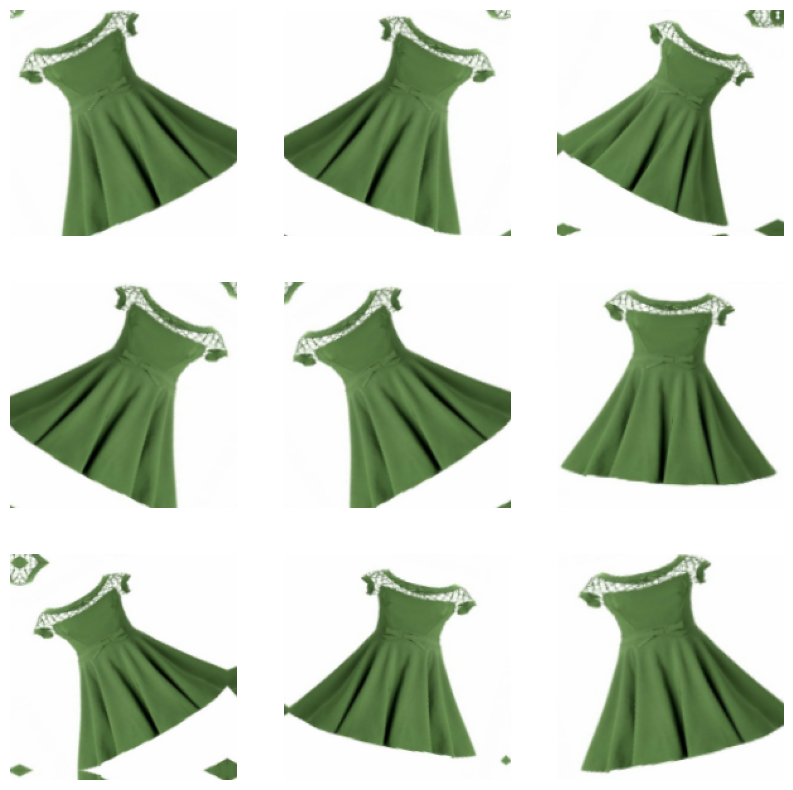

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[1].numpy().astype("uint8"))
    plt.axis("off")

create model

In [100]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes, name="outputs")
])

In [101]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [102]:

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_12 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                

In [103]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
4/4 [==============================] - 7s 1s/step - loss: 2.7957 - accuracy: 0.1509 - val_loss: 2.1157 - val_accuracy: 0.2727
Epoch 2/15
4/4 [==============================] - 4s 981ms/step - loss: 1.8962 - accuracy: 0.5283 - val_loss: 1.5619 - val_accuracy: 0.8182
Epoch 3/15
4/4 [==============================] - 6s 2s/step - loss: 1.3663 - accuracy: 0.6981 - val_loss: 1.2754 - val_accuracy: 0.4545
Epoch 4/15
4/4 [==============================] - 4s 1s/step - loss: 0.8844 - accuracy: 0.7075 - val_loss: 0.7910 - val_accuracy: 0.6364
Epoch 5/15
4/4 [==============================] - 5s 1s/step - loss: 0.7356 - accuracy: 0.7642 - val_loss: 1.1614 - val_accuracy: 0.7273
Epoch 6/15
4/4 [==============================] - 4s 1s/step - loss: 0.6402 - accuracy: 0.7830 - val_loss: 0.7928 - val_accuracy: 0.8182
Epoch 7/15
4/4 [==============================] - 4s 961ms/step - loss: 0.4354 - accuracy: 0.8585 - val_loss: 0.7091 - val_accuracy: 0.8182
Epoch 8/15
4/4 [===================

plot accuracy and loss

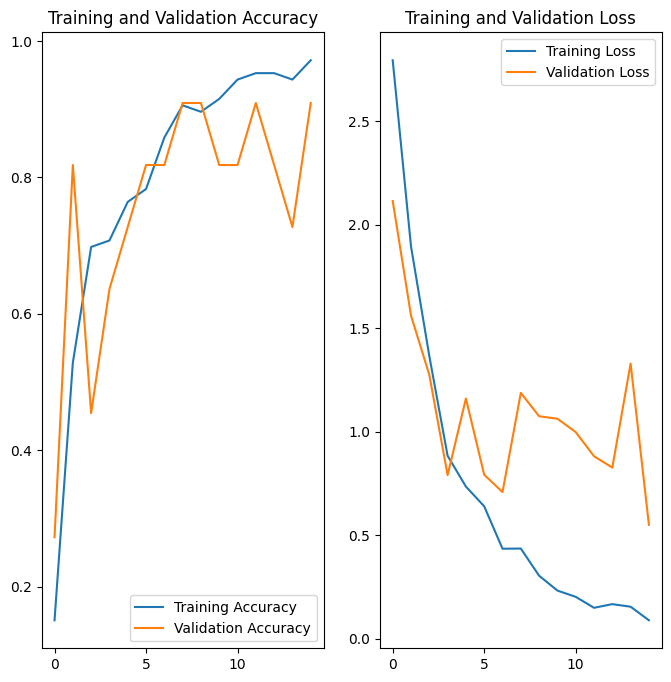

In [104]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

create test data


In [86]:
testimg=!unzip /content/testimg.zip

In [87]:
data_test_dir ='/content/testimg'

In [105]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 96 files belonging to 9 classes.


In [106]:
evaluate = model.evaluate(test_ds)
accuracy_model = evaluate[1]*100
print(f"accuracy_model = {accuracy_model}")


3/3 [==============================] - 2s 334ms/step - loss: 0.4157 - accuracy: 0.9271
accuracy_model = 92.70833134651184


predict some images from test_ds

1/1 [==============================] - 0s 336ms/step


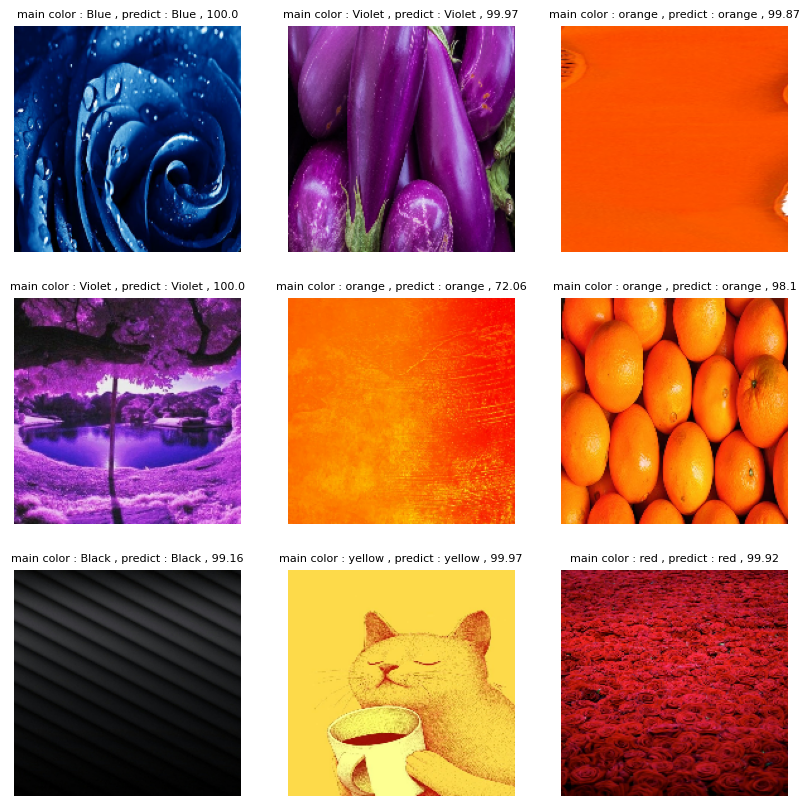

In [107]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):  # Take one batch of images
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        predictions = model.predict(images)
        score = tf.nn.softmax(predictions[i])
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"main color : {class_names[labels[i]]} , predict : {class_names[np.argmax(score)]} , {round(100 * np.max(score),2)}",fontsize=8, loc="center")
        plt.axis("off")
    plt.show()

*** 2- add noise - define noise factor - plot and evaluate from test_ds_noisy***




create noise test dataset

In [108]:

# Define noise factor
noise_factor = 1.7


# Function to add noise to images in a batch
def add_noise(images, labels):
    noisy_images = images + noise_factor * tf.random.normal(shape=tf.shape(images), dtype=tf.float32)

    return noisy_images, labels

# Apply noise to the test dataset
test_ds_noisy = test_ds.map(add_noise)

# Now you can use the test_ds_noisy for evaluation or further processing


1/1 [==============================] - 0s 342ms/step


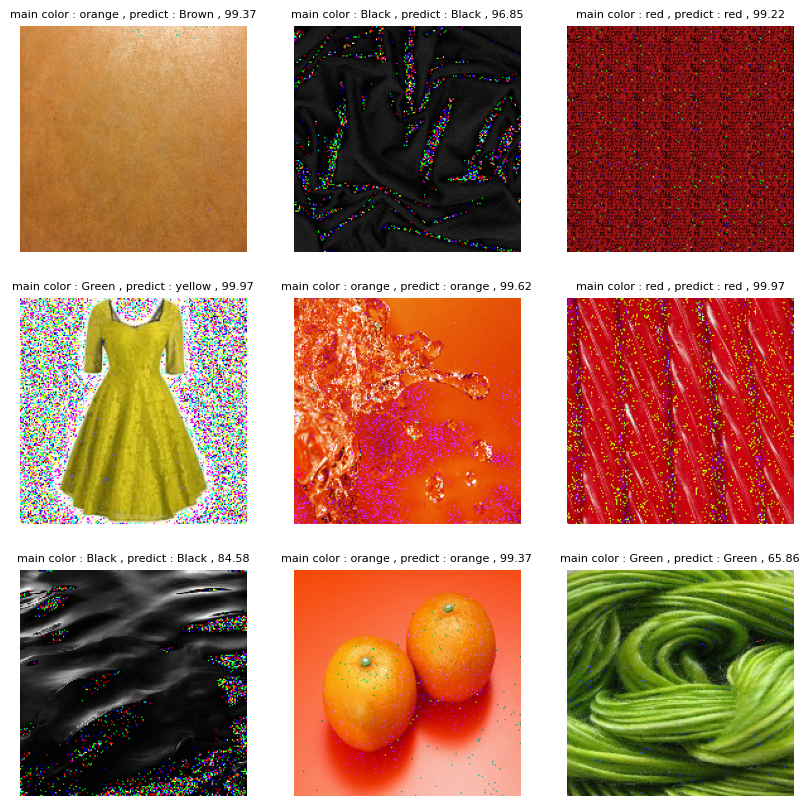

In [109]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds_noisy.take(1):  # Take one batch of images
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        predictions = model.predict(images)
        score = tf.nn.softmax(predictions[i])
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"main color : {class_names[labels[i]]} , predict : {class_names[np.argmax(score)]} , {round(100 * np.max(score),2)}",fontsize=8, loc="center")
        plt.axis("off")
    plt.show()



In [110]:
accuracy = model.evaluate(test_ds_noisy)
print(
    f"This model with noise_factor = {noise_factor} has accuracy  = {round(accuracy[1]*100,2)}"
)


3/3 [==============================] - 2s 351ms/step - loss: 0.4280 - accuracy: 0.9167
This model with noise_factor = 1.7 has accuracy  = 91.67



**3- network tolerance**



 model_accuracy - telorance with accuracy on noisy dataset = accuracy_model -2



In [111]:
accuracy_model

92.70833134651184

In [112]:

# Define the stopping accuracy threshold
stopping_accuracy = accuracy_model - 2



# Function to add noise to images in a batch
def add_noise(images, labels, noise_factor):
    noisy_images = images + noise_factor * tf.random.normal(shape=tf.shape(images), dtype=tf.float32)

    return noisy_images, labels

# Evaluate model on a dataset and return accuracy
def evaluate_model(model, dataset):
    result = model.evaluate(dataset)
    accuracy = result[1] * 100.0  # Convert accuracy to percentage
    return accuracy


# Loop through noise factors and evaluate the model
for noise_factor in range(0, 101, 1):
    print(f"Noise Factor: {noise_factor/10}")

    # Apply noise to the test dataset
    test_ds_noisy = test_ds.map(lambda x, y: add_noise(x, y, noise_factor))


    # Evaluate model on noisy dataset
    accuracy = evaluate_model(model, test_ds_noisy)
    print(f"Accuracy on Noisy Dataset: {accuracy:.2f}%")


    if accuracy < stopping_accuracy:
        print(f"Stopping training due to accuracy below {stopping_accuracy:.2f}%")
        break

Noise Factor: 0.0
3/3 [==============================] - 3s 351ms/step - loss: 0.4157 - accuracy: 0.9271
Accuracy on Noisy Dataset: 92.71%
Noise Factor: 0.1
3/3 [==============================] - 2s 347ms/step - loss: 0.4209 - accuracy: 0.9167
Accuracy on Noisy Dataset: 91.67%
Noise Factor: 0.2
3/3 [==============================] - 2s 354ms/step - loss: 0.4320 - accuracy: 0.9062
Accuracy on Noisy Dataset: 90.62%
Stopping training due to accuracy below 90.71%


now plot with Noise Factor that stopped model with accuracy on noisy dataset = accuracy_model -2

noise_factor = 0.02 and accuracy : 90.62%
1/1 [==============================] - 0s 345ms/step


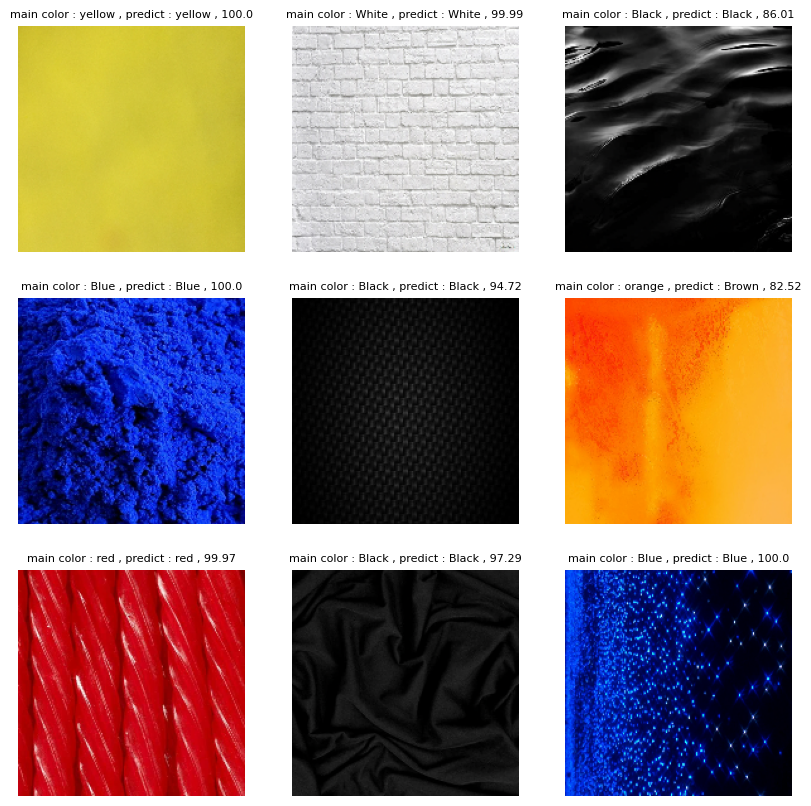

In [114]:
noise_factor = noise_factor/10
print(f"noise_factor = {noise_factor} and accuracy : {accuracy:.2f}%")

# Function to add noise to images in a batch
def add_noise(images, labels):
    noisy_images = images + noise_factor * tf.random.normal(shape=tf.shape(images), dtype=tf.float32)
    return noisy_images, labels

# Apply noise to the test dataset
test_ds_noisy = test_ds.map(add_noise)



plt.figure(figsize=(10, 10))
for images, labels in test_ds_noisy.take(1):  # Take one batch of images
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        predictions = model.predict(images)
        score = tf.nn.softmax(predictions[i])
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"main color : {class_names[labels[i]]} , predict : {class_names[np.argmax(score)]} , {round(100 * np.max(score),2)}",fontsize=8, loc="center")
        plt.axis("off")
    plt.show()